In [30]:
!pip install --quiet altair
#!pip show altair

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import altair as alt

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from pandasticsearch import Select, DataFrame

In [4]:
from fbprophet import Prophet

In [29]:
hostname="http://10.24.179.153:9200"
client =  Elasticsearch(hostname, http_compress=True, timeout=300)
#client.cluster.health()

In [6]:
resp = client.search(
    index="shasta-logs-*",
    body={
        "size":0,
        "query": {
            "bool": {
              "must": [{
                  "match_all": {}
                },
                {
                  "range": {
                    "timereported": {
                      "gte": "2019-06-01",
                      "lte": "2020-01-30",
                      "format": "yyyy-MM-dd HH:mm:ss||yyyy-MM-dd||epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      },
        "_source":{
            "excludes":[]
        },
        "aggs": {
        "2": {
          "date_histogram": {
            "field": "timereported",
            "interval": "1h",
            "time_zone": "America/Chicago",
            "min_doc_count": 1
          }
        }
      }
    }
)

INFO:elasticsearch:GET http://10.24.179.153:9200/shasta-logs-*/_search [status:200 request:7.407s]


In [11]:
table=resp['aggregations']['2']['buckets']
data_as_frame=pd.DataFrame.from_dict(table)
data_as_frame = data_as_frame.rename(columns={'key_as_string':'Date','doc_count':'Count'})
data_as_frame.tail(5)

,Count,key,Date
73,844605,1578344400000,2020-01-06T15:00:00.000-06:00
74,856231,1578348000000,2020-01-06T16:00:00.000-06:00
75,852342,1578351600000,2020-01-06T17:00:00.000-06:00
76,861013,1578355200000,2020-01-06T18:00:00.000-06:00
77,280323,1578358800000,2020-01-06T19:00:00.000-06:00


In [12]:
data_as_frame.columns

Index(['Count', 'key', 'Date'], dtype='object')

In [13]:
data_as_frame['Count'].describe().apply(lambda x: format(x, '.2f'))

count          78.00
mean      1643038.58
std       2857873.49
min        280323.00
25%        852376.75
50%        938490.00
75%       1007308.50
max      20315429.00
Name: Count, dtype: object

In [15]:
# Cleaning the df, we only need two columns date time and the data
clean_df=data_as_frame[['Date','Count']].copy()
clean_df['Date'] = pd.to_datetime(clean_df['Date'].astype(str), format='%Y-%m-%d %H:%M:%S')
clean_df['Date'] = clean_df['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
clean_df.head()

,Date,Count
0,2020-01-03 20:00:00,537752
1,2020-01-03 21:00:00,13807315
2,2020-01-03 22:00:00,20315429
3,2020-01-03 23:00:00,9460067
4,2020-01-04 00:00:00,5949829


In [21]:
alt.Chart(clean_df).mark_point(size=20, opacity=0.7, color = 'steelblue').encode(
        x='Date:T',
        y=alt.Y('Count', title='Count'),    
        tooltip=['yearmonthdate(Date)', 'Count']
    ).interactive().properties(width=900, height=450,title='Log Messages per hour')\
              .configure_title(fontSize=20)

alt.Chart(...)

Displaying Prophet plot


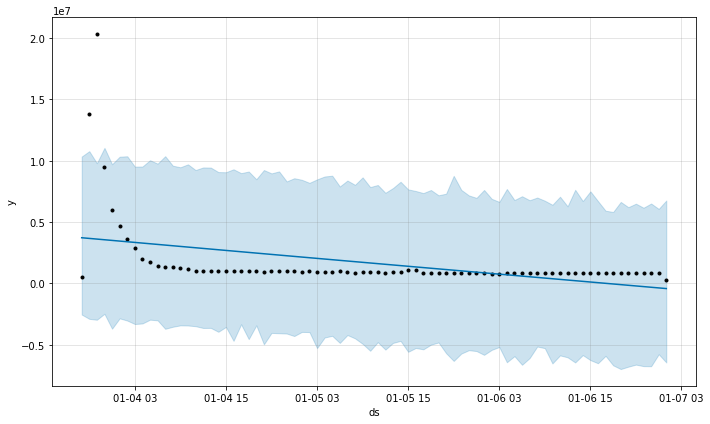

In [40]:
clean_df.columns = ['ds','y']
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, 
                yearly_seasonality = False, 
                weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(clean_df)

In [25]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2020-01-03 20:00:00,3.723753e+06,3.723753e+06,-3.178914e+06,1.027892e+07,537752,0,0.000000
1,2020-01-03 21:00:00,3.669371e+06,3.669371e+06,-2.338366e+06,9.601940e+06,13807315,1,0.304576
2,2020-01-03 22:00:00,3.614989e+06,3.614989e+06,-3.461168e+06,9.760741e+06,20315429,1,0.519540
3,2020-01-03 23:00:00,3.560606e+06,3.560606e+06,-3.953846e+06,1.065062e+07,9460067,0,0.000000
4,2020-01-04 00:00:00,3.506224e+06,3.506224e+06,-3.183061e+06,9.359357e+06,5949829,0,0.000000


In [26]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Message Counts'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Message Counts'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

Displaying Prophet plot


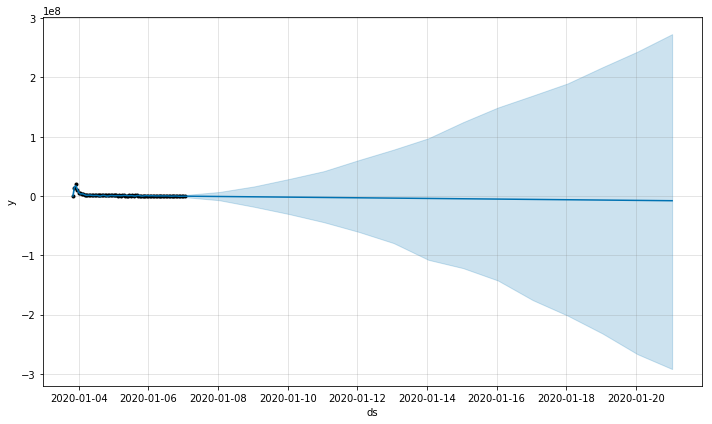

In [34]:
def plot_forecast(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = True, 
                yearly_seasonality = False, 
                weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    future = m.make_future_dataframe(periods=14)
    forecast = m.predict(future)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig3 = m.plot(forecast)
    
plot_forecast(clean_df)